In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pylab as plt

sns.set_style('white')

DATA = '../data/'

Administrative districts lookup

In [2]:
aimag_lookup = {'UB':'Ulaanbaatar',
            'DO':'Dornod',
            'SB':"Su'xbaatar", 
            'KhE':'Xentii',
            'TU':"To'v",
            'GS':"Govisu'mber", 
            'BG':'Dornogovi',
            'DA':'Darxan-Uul',
            'DU':'Dundgovi',
            'OR':'Orxon',
            'UV':"O'vorxangai", 
            'BU':'Bulgan',
            'BKh':'Bayanxongor',
            'AR':'Arxangai',
            'KhU':"Xo'vsgol",
            'ZA':'Zavxan',
            'GA':'Govi-Altai',
            'Bay':"Bayan-O'lgii", 
            'KhO':'Xovd',
            'UG':"O'mnogovi", 
            'UVs':'Uvs',
            'SE':'Selenge'}

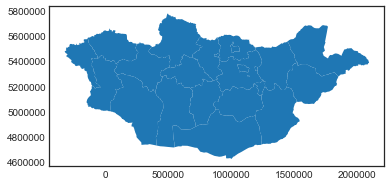

In [3]:
aimag_map = gpd.read_file(DATA+'GIS/aimag_boundaries/aimags_alagac_utm.shp').drop('NAME_L1', axis=1)
aimag_map.plot()

In [4]:
aimag_map['Province'] = aimag_map.NAME.replace({aimag_lookup[code]:code for code in aimag_lookup})

Import line list

In [5]:
line_list = pd.read_csv(DATA+'clean/line_list.csv', parse_dates=['date_onset', 'dob', 'date_lab'])

In [6]:
lab_samples = line_list.dropna(subset=['date_lab', 'date_onset']).copy()
lab_samples.head()

,id,date_onset,provincecity,dob,age_years,died,confirmed,labconfirmed,date_lab,vaccine_ever,male,month_onset,year_onset
0,389.0,2015-03-30,UB,2014-09-01,0.577686,0.0,1.0,1.0,2015-04-06,0.0,True,3.0,2015.0
1,707.0,2015-04-03,UB,2013-02-02,2.162902,1.0,1.0,1.0,2015-04-04,0.0,True,4.0,2015.0
3,2061.0,2015-04-22,UB,2014-09-23,0.577686,0.0,1.0,1.0,2015-04-24,0.0,True,4.0,2015.0
8,20835.0,2015-11-25,UB,2015-09-01,0.238193,1.0,1.0,1.0,2015-12-01,0.0,True,11.0,2015.0
9,21053.0,2015-12-02,UB,2014-11-19,1.062286,0.0,1.0,1.0,2015-12-14,0.0,False,12.0,2015.0


Tally of clinic- and lab-confirmed cases

In [7]:
pd.crosstab(lab_samples.confirmed, lab_samples.labconfirmed)

labconfirmed,0.0,1.0
confirmed,,
0.0,1210,0
1.0,1848,3993


Lab-confirmed counts (log-transformed) mapped by province

/Users/fonnescj/anaconda3/envs/dev/lib/python3.6/site-packages/matplotlib/colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


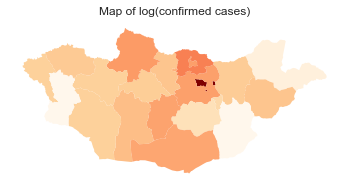

In [8]:
ax = (aimag_map.join(lab_samples.assign(NAME=lab_samples.provincecity.replace(aimag_lookup))
                 .groupby('NAME')
                 .labconfirmed.sum().apply(np.log), on='NAME')
             .plot(column='labconfirmed', cmap='OrRd'))
ax.set_xticks([])
ax.set_yticks([])
ax.set_frame_on(False)
ax.set_title('Map of log(confirmed cases)');

The time from date of onset to lab confirmation

In [9]:
lab_samples['onset_to_lab_days'] = (lab_samples.date_lab - lab_samples.date_onset).dt.days

In [10]:
lab_samples['onset_to_lab_weeks'] = (lab_samples['onset_to_lab_days']/7).astype(int)

Negative values for `onset_to_lab` treated as missing

In [11]:
lab_samples = lab_samples[lab_samples.onset_to_lab_days>0]

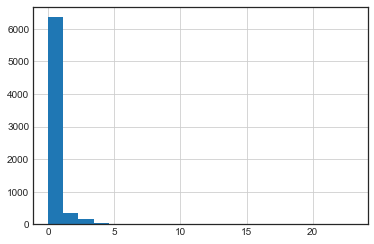

In [12]:
lab_samples.onset_to_lab_weeks.hist(bins=20)

Age distribution

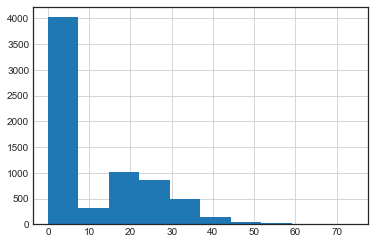

In [13]:
lab_samples.age_years.hist()

Extract clinic-confirmed cases

In [14]:
clinic_confirmed = lab_samples.query('confirmed==1')

In [15]:
clinic_confirmed.isnull().sum()

id                       0
date_onset               0
provincecity             2
dob                     20
age_years               20
died                     0
confirmed                0
labconfirmed             0
date_lab                 0
vaccine_ever          1774
male                     0
month_onset              0
year_onset               0
onset_to_lab_days        0
onset_to_lab_weeks       0
dtype: int64

### Reporting lag model

In [16]:
from pymc3 import sample, Model, invlogit, fit, generator, DensityDist, sample_ppc, find_MAP
from pymc3 import Deterministic, SVGD, GaussianRandomWalk, EllipticalSlice
from pymc3.gp import cov, Latent
from pymc3 import MvNormal, Normal, Bernoulli, Gamma, HalfCauchy, Uniform, Flat, Binomial, Exponential, HalfNormal
from pymc3 import traceplot, forestplot, summary, generator, energyplot
from pymc3.math import invprobit, invlogit
from pymc3.gp.util import plot_gp_dist

import theano.tensor as tt
from theano import shared

/Users/fonnescj/anaconda3/envs/dev/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [18]:
lag, n, confirmed = clinic_confirmed.groupby('onset_to_lab_weeks').labconfirmed.agg(['count', 'sum']).reset_index().values.T

In [20]:
clinic_confirmed.groupby('onset_to_lab_weeks').labconfirmed.agg(['count', 'sum']).reset_index()

,onset_to_lab_weeks,count,sum
0,0,3721,2442.0
1,1,1513,1120.0
2,2,322,221.0
3,3,158,119.0
4,4,38,33.0
5,5,10,7.0
6,6,4,4.0
7,7,4,3.0
8,8,4,2.0
9,9,2,2.0


In [28]:
with Model() as lag_model:
    
    ρ = Exponential('ρ', 1)
    η = Exponential('η', 1)
    
    K = η**2 * cov.ExpQuad(1, ρ)
    gp = Latent(cov_func=K)
    f = gp.prior('f', X=lag[:, None])
    
    σ = HalfNormal('σ', 3)
    ϵ = Normal('ϵ', 0, sd=σ, shape=len(n))
    
    π = Deterministic('π', invlogit(f + ϵ))
    
    confirmation = Binomial('confirmation', p=π, n=n.astype(int), observed=confirmed.astype(int))

In [29]:
with lag_model:
#     lag_approx = fit(30000)
#     lag_trace = lag_approx.sample(1000)
    lag_trace = sample(1000, tune=2000)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ϵ, σ_log__, f_rotated_, η_log__, ρ_log__]
100%|██████████| 3000/3000 [03:29<00:00, 14.32it/s]
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


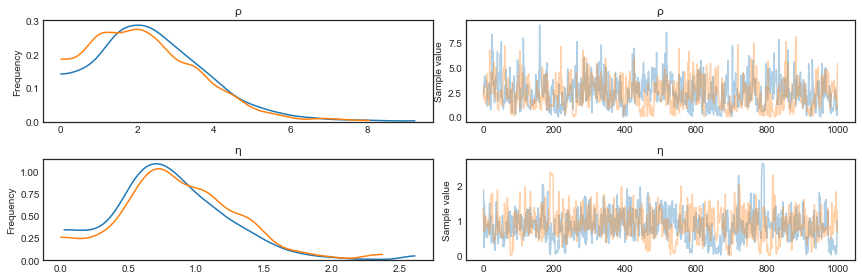

In [30]:
traceplot(lag_trace, varnames=['ρ', 'η']);

In [31]:
lag_data = pd.DataFrame({'lag': lag,
                        'obs': confirmed})

In [32]:
lag_grid = np.linspace(0, 160, 200)[:,None]

# add the GP conditional to the model, given the new X values
with lag_model:
    f_pred = gp.conditional("f_pred", lag_grid)

In [33]:
with lag_model:
    y_pred = sample_ppc(lag_trace, vars=[f_pred], samples=1000)

100%|██████████| 1000/1000 [00:04<00:00, 212.36it/s]


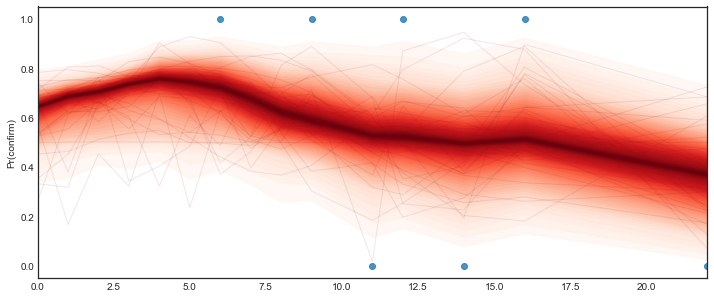

In [34]:
plt.figure(figsize=(12,5))
ax = sns.regplot(lag, confirmed/n, fit_reg=False)

plot_gp_dist(ax, 1/(1+np.exp(-lag_trace["f"])), lag[:, None])
ax.set_xlim(0,max(lag))
ax.set_ylabel('Pr(confirm)');

### Age model

In [36]:
age_data = clinic_confirmed.dropna(subset=['age_years']).copy()

In [37]:
age_data['age_months'] = (age_data.age_years*12).astype('int')

In [38]:
age_data.loc[:, 'age_years'] = age_data.age_years.astype(int)

In [39]:
age, n, confirmed = age_data.groupby('age_years').labconfirmed.agg(['count', 'sum']).reset_index().values.T

In [41]:
age_data.groupby('age_years').labconfirmed.agg(['count', 'sum'])

,count,sum
age_years,,
0,2767,2130.0
1,317,188.0
2,113,82.0
3,71,57.0
4,49,34.0
5,42,30.0
6,40,33.0
7,67,57.0
8,47,39.0


In [131]:
with Model() as age_model:
    
    ϕ = Exponential('ϕ', 1)
    β = Exponential('β', 1)
    
    K = β**2 * cov.Matern32(1, ϕ)
    gp = Latent(cov_func=K)
    g = gp.prior('g', X=age[:, None])
    
    σ = HalfNormal('σ', 3)
    ϵ = Normal('ϵ', 0, sd=σ, shape=len(n))
    
    θ = Deterministic('θ', invlogit(g + ϵ))
    
    confirmation_age = Binomial('confirmation_age', p=θ, n=n.astype(int), observed=confirmed.astype(int))

In [133]:
with age_model:
    
    trace_age = sample(1000, tune=2000, nuts_kwargs=dict(target_accept=0.99))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ϵ, σ_log__, g_rotated_, β_log__, ϕ_log__]
100%|██████████| 3000/3000 [09:49<00:00,  8.15it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


In [124]:
# with age_model:
#     approx = fit(10000, method='fullrank_advi')
#     trace_age = approx.sample(1000)

Average Loss = 195.82: 100%|██████████| 10000/10000 [00:20<00:00, 494.87it/s]
Finished [100%]: Average Loss = 195.83


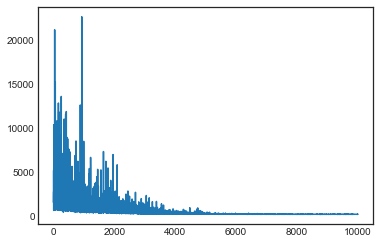

In [125]:
plt.plot(approx.hist)

In [134]:
predictions = pd.DataFrame({'age': age,
                            'obs': confirmed})

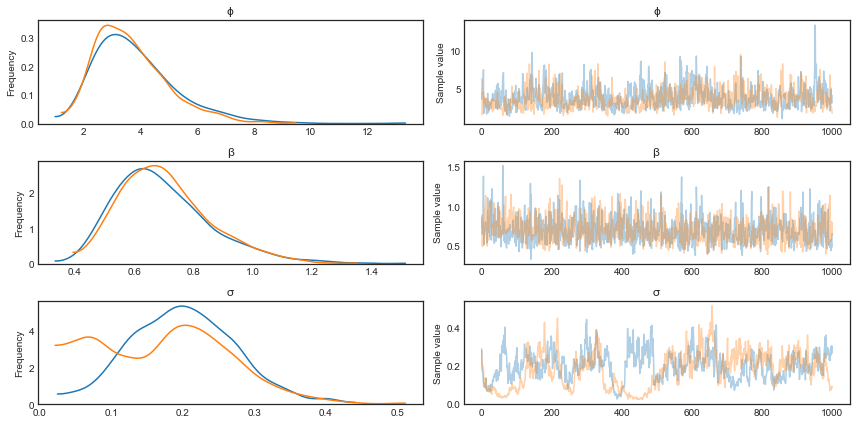

In [135]:
traceplot(trace_age, varnames=['ϕ', 'β', 'σ']);

In [136]:
age_grid = np.linspace(0, 75, 200)[:,None]

# add the GP conditional to the model, given the new X values
with age_model:
    g_pred = gp.conditional("g_pred", age_grid)

In [137]:
with age_model:
    y_pred = sample_ppc(trace_age, vars=[g_pred], samples=1000)

100%|██████████| 1000/1000 [00:07<00:00, 129.38it/s]


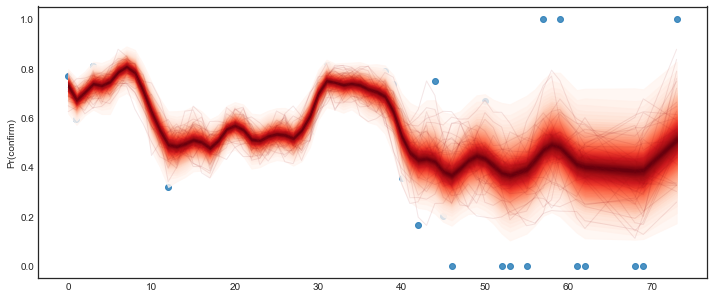

In [138]:
from pymc3.gp.util import plot_gp_dist

plt.figure(figsize=(12,5))
ax = sns.regplot(age, confirmed/n, fit_reg=False)

plot_gp_dist(ax, 1/(1+np.exp(-trace_age["g"])), age[:, None])
ax.set_ylabel('Pr(confirm)');

## Combined model

In [42]:
age, lag, n, confirmed = (age_data.groupby(['age_years', 'onset_to_lab_weeks'])
                              .labconfirmed.agg(['count', 'sum']).reset_index().values.T)

In [78]:
X = np.c_[age, lag]

In [70]:
X.shape

(226, 2)

In [90]:
with Model() as combined_model:
    
    ρ = HalfCauchy('ρ', 1, shape=(2,))
    η = HalfCauchy('η', 1)
    
    K = η**2 * cov.Matern32(2, ρ)
    gp = Latent(cov_func=K)
    f = gp.prior('f', X=X)
    
    σ = HalfNormal('σ', 3)
    ϵ = Normal('ϵ', 0, sd=σ, shape=len(n))
    
    π = Deterministic('π', invlogit(f + ϵ))
    
    confirmation = Binomial('confirmation', p=π, n=n.astype(int), observed=confirmed.astype(int))

In [91]:
with combined_model:
    
    trace_combined = sample(1000, tune=3000, nuts_kwargs=dict(target_accept=0.99))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ϵ, σ_log__, f_rotated_, η_log__, ρ_log__]
  0%|          | 0/4000 [00:00<?, ?it/s]Process ForkPoolWorker-32:
Process ForkPoolWorker-31:


KeyboardInterrupt: 

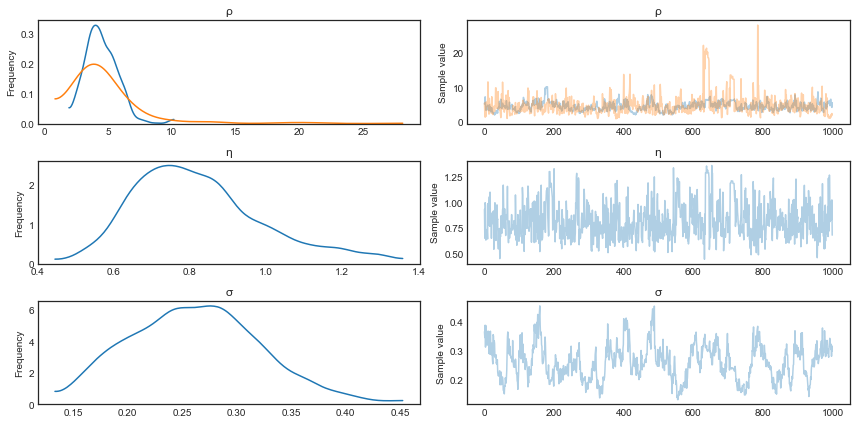

In [82]:
traceplot(trace_combined, varnames=['ρ', 'η', 'σ']);

In [83]:
age_grid = np.linspace(0, 70, 20)
lag_grid = np.linspace(0, 20, 20)

age_vals, lag_vals = np.meshgrid(age_grid, lag_grid)

In [84]:
X_vals = np.c_[age_vals.ravel(), age_vals.ravel()]

In [85]:
with combined_model:
    f_pred = gp.conditional("f_pred", X_vals)

In [86]:
with combined_model:
    y_pred = sample_ppc(trace_combined, vars=[f_pred], samples=200)

100%|██████████| 200/200 [00:04<00:00, 52.43it/s]


In [87]:
from matplotlib.mlab import griddata

y_pred['f_pred'].mean(0).shape

(400,)

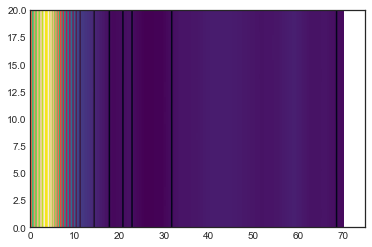

In [89]:
xi = np.linspace(0, 75, 200)
yi = np.linspace(0, 20, 200)
zi = griddata(age_vals.ravel(), lag_vals.ravel(), y_pred['f_pred'].mean(0), xi, yi, interp='linear')

plt.contour(xi, yi, zi, 15)
plt.pcolormesh(xi, yi, zi, cmap = plt.get_cmap('viridis'))